In [1]:
from int_green3d import *
from potential_initialization import *
import trimesh
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
mesh = trimesh.load_mesh("models/junction.stl")
nov, nof, nop = len(mesh.vertices), len(mesh.faces), len( trimesh.graph.connected_components(mesh.edges))
# faces and triagles are used interchangably

print("number of vertices: " + str(nov))
print("number of faces: " + str(nof))
print("number of connected parts: " + str(nop))

number of vertices: 1070
number of faces: 886
number of connected parts: 94


In [3]:
# index connected parts and label each vertex with its part's index.
label_vertices = trimesh.graph.connected_component_labels(mesh.edges)
label_triagles = [label_vertices[triagle[0]] for triagle in mesh.faces]

# a list of connected parts defined by their composite triagles
parts = [[] for i in range(nop)]
for idx, part_idx in enumerate(label_triagles):
    parts[part_idx].append(idx)

# indexing the vertices, faces and connected parts
coordinate2idx = dict()
triagle2idx = dict()
part2idx = dict()


def face_hash(face):
    '''
    return a hashable tuple that contains a small triagle's information.
    '''
    if face.shape == (3, ):
        return triagle2idx[tuple(sorted(face))]
    return triagle2idx[tuple(sorted([coordinate2idx[tuple(vertex)] for vertex in face]))]


for idx, vertex in enumerate(mesh.vertices):
    coordinate2idx[tuple(vertex)] = idx

for idx, face in enumerate(mesh.faces):
    triagle2idx[tuple(sorted(face))] = idx

for idx, part in enumerate(parts):
    part2idx[tuple(sorted(part))] = idx

In [4]:
import os
q = 1.6e-19
m = 0.171/6.02e23
omega_rf = 2 * np.pi * 30e6
V_rf = 170
PSCoef = (q / (4 * m * omega_rf ** 2)) * V_rf ** 2

%load_ext autoreload
%autoreload 2

shuttle_range = [[-1, 1], [-0.1, 0.1], [0.05, 0.1]]
# test of the function with sparse field points
field_points = get_field_points(shuttle_range)
field_points = np.transpose(field_points, (1, 2, 3, 0))
pb, pp = get_potential_basis("junction", PSCoef, field_points, regenerate=False)
pb.shape

(400, 40, 10, 94)

In [5]:
pb, pp = get_potential_basis("junction", PSCoef, regenerate=False)
pb.shape, pp.shape

((400, 40, 10, 94), (400, 40, 10))

In [6]:


voltage = np.random.uniform(-5, 5, size=94)
tp = get_total_potential(voltage, pb, pp)

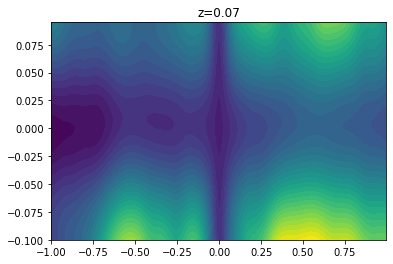

In [11]:
%matplotlib inline 
voltage = np.random.uniform(-10, 10, size=94)
slice = display.total_potential_slice(voltage, pb, pp, shuttle_range, 0.07)

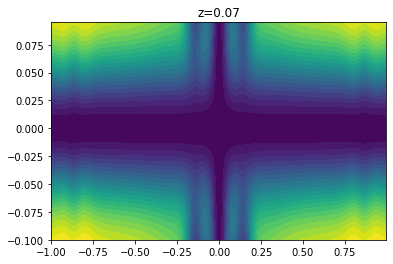

In [7]:
import display 
%matplotlib inline 
voltage = np.zeros(nop)
slice = display.total_potential_slice(voltage, pb, pp, shuttle_range, 0.07)

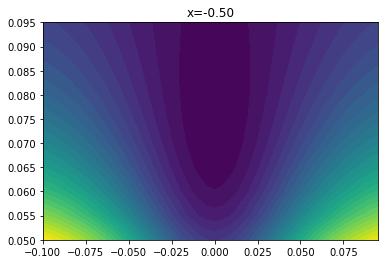

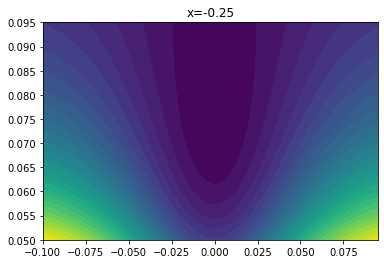

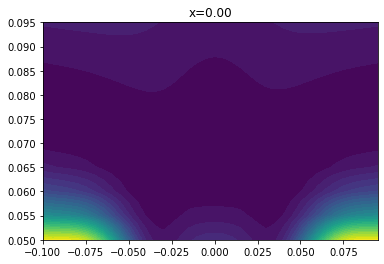

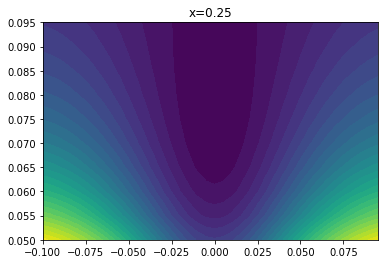

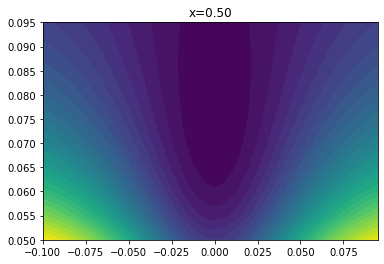

In [8]:
for i in np.linspace(-0.5, 0.5, 5):
    display.potential_slicex(pp, shuttle_range, i)

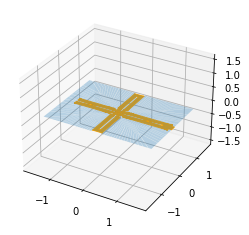

In [14]:
display.part(mesh, 0)

In [16]:
get_charge_basis("junction", regenerate=True)

  0%|          | 3/886 [00:00<00:42, 20.73it/s]

Calculating charge basis


100%|██████████| 886/886 [00:51<00:00, 17.33it/s]


array([[ 3.37580197e+01,  2.77671280e+01,  2.02577486e+01, ...,
        -2.13194549e+01, -2.13414579e+01, -1.15895310e+01],
       [-1.47396872e+01, -1.82542486e+01, -1.08458871e+00, ...,
        -1.37193697e+00, -1.36779187e+00,  3.61812222e-01],
       [-8.38015760e-03, -8.13548655e-03, -3.16422802e-02, ...,
        -3.18200335e-02, -1.47215755e-02, -2.16372155e-02],
       ...,
       [-6.86205148e-03, -7.23069792e-03, -1.36206107e-02, ...,
        -2.20971830e-01, -5.90479374e-03, -8.75898729e-03],
       [-9.47603723e-03, -1.05857464e-02, -1.35237918e-02, ...,
         4.04800129e+01, -5.60705972e-03, -8.48340648e-03],
       [-7.68212708e-03, -8.21067915e-03, -2.33312330e+00, ...,
        -5.65356286e-03,  4.04841042e+01,  4.05777165e+01]])

In [10]:
# loading data from https://github.com/iontrapnet/BEM
import pandas as pd
import scipy.io

charge_basis = get_charge_basis("junction")

mat = scipy.io.loadmat('previous_data/chargebasis.mat')
mat["cb"].shape, charge_basis.shape
previous_triag = np.moveaxis(mat["triangles"], 2, 0)
previous_cb = np.moveaxis(mat["cb"], 0, 1)


csv=r'previous_data/nodes&parts.csv'
nn,ne=pd.read_csv(csv,header=None,nrows=1).to_numpy()[0]
df=pd.read_csv(csv,header=None,skiprows=1).to_numpy()
previous_parts = []
print(ne)
for i in range(ne):
    m = int(df[nn][0])
    set_of_triagles = [face_hash(triag) for triag in df[nn+1:nn+m+1]-1]
    previous_parts.append(set_of_triagles)
    nn += m+1

# Check if the indexing of parts is consistent with the previous definition
for idx, part in enumerate(previous_parts):
    assert part2idx[tuple(sorted(part))] == idx

# check if charge basis is correct
sorted(abs((charge_basis /  previous_cb).reshape(nof * nop) - 1), reverse=True)[:20]

94


[0.00949953945939197,
 0.008218999782153569,
 0.004151164546435937,
 0.0027556509759791847,
 0.0027241223121556857,
 0.001786374322391815,
 0.0015610899948818036,
 0.0012885440604523124,
 0.0012269548443171185,
 0.0007343633531174953,
 0.0007162992848532834,
 0.0006439705102333493,
 0.000637742654473028,
 0.000595261364232158,
 0.0004771680148052404,
 0.0003897818407210263,
 0.0003545406457563516,
 0.00026161098312349473,
 0.00023915452523226577,
 0.00014770038469369418]